In [2]:
import json
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import re

# Load a sample from the dataset to understand the structure
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v2", split='train')

# Examine a sample
sample = dataset[0]
print(f"Keys in sample: {list(sample.keys())}")

Keys in sample: ['image', 'id', 'parsed_data', 'raw_data']


In [6]:
# Examine a sample
sample = dataset[0]
print(f"Keys in sample: {list(sample.keys())}")

# Parse the raw_data
if 'raw_data' in sample:
    try:
        raw_data = json.loads(sample['raw_data'])
        print(f"Keys in raw_data: {list(raw_data.keys())}")
        
        # Check the structure of ocr_boxes
        if 'ocr_boxes' in raw_data:
            ocr_boxes = raw_data['ocr_boxes']
            print(f"Number of boxes: {len(ocr_boxes)}")
            
            # Examine first few boxes
            for i in range(min(3, len(ocr_boxes))):
                box = ocr_boxes[i]
                print(f"\nBox {i+1}:")
                print(f"Type: {type(box)}")
                print(f"Content: {box}")
                
                # If it's a list, extract components
                if isinstance(box, list) and len(box) >= 2:
                    polygon = box[0]
                    text_conf = box[1]
                    
                    print(f"Polygon type: {type(polygon)}")
                    print(f"Text_conf type: {type(text_conf)}")
                    
                    # Try to extract text and confidence
                    if isinstance(text_conf, tuple) or isinstance(text_conf, list):
                        if len(text_conf) >= 2:
                            text = text_conf[0]
                            conf = text_conf[1]
                            print(f"Text: '{text}', Confidence: {conf}")
    except Exception as e:
        print(f"Error parsing raw_data: {e}")

Keys in sample: ['image', 'id', 'parsed_data', 'raw_data']
Keys in raw_data: ['ocr_words', 'ocr_boxes', 'ocr_labels']
Number of boxes: 7196

Box 1:
Type: <class 'str'>
Content: [

Box 2:
Type: <class 'str'>
Content: [

Box 3:
Type: <class 'str'>
Content: [


In [7]:
# Examine a sample
sample = dataset[0]
print(f"Keys in sample: {list(sample.keys())}")

# Let's inspect the raw ocr_boxes string
if 'raw_data' in sample:
    raw_data = json.loads(sample['raw_data'])
    if 'ocr_boxes' in raw_data:
        ocr_boxes = raw_data['ocr_boxes']
        print(f"Type of ocr_boxes: {type(ocr_boxes)}")
        print(f"First 200 characters of ocr_boxes: {ocr_boxes[:200]}")
        
        # Try to extract the first complete box using regex
        box_pattern = r"\[\[\[(.*?)\]\], \((.*?)\)\]"
        matches = re.findall(box_pattern, ocr_boxes)
        
        if matches:
            print(f"Found {len(matches)} box patterns")
            first_match = matches[0]
            print(f"First box pattern: {first_match}")
            
            # Parse the coordinates and text/confidence
            coords_str, text_conf_str = first_match
            
            # Parse coordinates
            coords_pattern = r"(\d+\.\d+), (\d+\.\d+)"
            coord_matches = re.findall(coords_pattern, coords_str)
            
            if coord_matches:
                print(f"Coordinates: {coord_matches}")
                
                # Extract points
                points = []
                for x_str, y_str in coord_matches:
                    points.append([float(x_str), float(y_str)])
                
                print(f"Points: {points}")
                
                # Calculate bounding box
                x_vals = [p[0] for p in points]
                y_vals = [p[1] for p in points]
                x1, y1 = min(x_vals), min(y_vals)
                x2, y2 = max(x_vals), max(y_vals)
                print(f"Bounding box (x1,y1,x2,y2): {x1}, {y1}, {x2}, {y2}")
            
            # Parse text and confidence
            text_conf_pattern = r"'(.*?)', ([\d\.]+)"
            text_conf_match = re.search(text_conf_pattern, text_conf_str)
            
            if text_conf_match:
                text = text_conf_match.group(1)
                conf = float(text_conf_match.group(2))
                print(f"Text: '{text}', Confidence: {conf}")

Keys in sample: ['image', 'id', 'parsed_data', 'raw_data']
Type of ocr_boxes: <class 'str'>
First 200 characters of ocr_boxes: [[[[229.0, 368.0], [271.0, 372.0], [269.0, 392.0], [228.0, 388.0]], ('1%', 0.6566713452339172)], [[[301.0, 367.0], [496.0, 363.0], [497.0, 386.0], [301.0, 390.0]], ('Nasi Campur Bali', 0.9592267870903
Found 71 box patterns
First box pattern: ('[229.0, 368.0], [271.0, 372.0], [269.0, 392.0], [228.0, 388.0', "'1%', 0.6566713452339172")
Coordinates: [('229.0', '368.0'), ('271.0', '372.0'), ('269.0', '392.0'), ('228.0', '388.0')]
Points: [[229.0, 368.0], [271.0, 372.0], [269.0, 392.0], [228.0, 388.0]]
Bounding box (x1,y1,x2,y2): 228.0, 368.0, 271.0, 392.0
Text: '1%', Confidence: 0.6566713452339172


In [10]:
# Function to parse ocr_boxes string into structured data
def parse_ocr_boxes(ocr_boxes_str):
    """Parse ocr_boxes string into a list of [bbox, text, confidence]"""
    words = []
    boxes = []
    confidences = []
    
    # Extract each box using regex
    box_pattern = r"\[\[\[(.*?)\]\], \((.*?)\)\]"
    matches = re.findall(box_pattern, ocr_boxes_str)
    
    for coords_str, text_conf_str in matches:
        try:
            # Parse coordinates
            coords_pattern = r"(\d+\.\d+), (\d+\.\d+)"
            coord_matches = re.findall(coords_pattern, coords_str)
            
            if not coord_matches or len(coord_matches) < 3:
                continue
                
            # Extract points
            points = []
            for x_str, y_str in coord_matches:
                points.append([float(x_str), float(y_str)])
            
            # Calculate bounding box
            x_vals = [p[0] for p in points]
            y_vals = [p[1] for p in points]
            x1, y1 = min(x_vals), min(y_vals)
            x2, y2 = max(x_vals), max(y_vals)
            
            # Parse text and confidence
            text_conf_pattern = r"'(.*?)', ([\d\.]+)"
            text_conf_match = re.search(text_conf_pattern, text_conf_str)
            
            if text_conf_match:
                text = text_conf_match.group(1)
                conf = float(text_conf_match.group(2))
                
                # Add to lists
                words.append(text)
                boxes.append([x1, y1, x2, y2])
                confidences.append(conf)
        except Exception as e:
            print(f"Error parsing box: {e}")
            continue
    
    return words, boxes, confidences

In [9]:
# Function to parse the raw_data field
def parse_raw_data(sample):
    """Parse raw_data field to extract words, boxes, and confidences"""
    words = []
    boxes = []
    confidences = []
    
    if 'raw_data' not in sample:
        return words, boxes, confidences
        
    try:
        raw_data = json.loads(sample['raw_data'])
        
        if 'ocr_boxes' in raw_data:
            ocr_boxes_str = raw_data['ocr_boxes']
            words, boxes, confidences = parse_ocr_boxes(ocr_boxes_str)
                    
        return words, boxes, confidences
        
    except Exception as e:
        print(f"Error parsing raw_data: {e}")
        return words, boxes, confidences

In [11]:
# Test the parsing function
words, boxes, confidences = parse_raw_data(sample)
print(f"\nParsed {len(words)} words with bounding boxes")
for i in range(min(5, len(words))):
    print(f"Word: '{words[i]}', Box: {boxes[i]}, Confidence: {confidences[i]}")


Parsed 71 words with bounding boxes
Word: '1%', Box: [228.0, 368.0, 271.0, 392.0], Confidence: 0.6566713452339172
Word: 'Nasi Campur Bali', Box: [301.0, 363.0, 497.0, 390.0], Confidence: 0.9592267870903015
Word: '75,000', Box: [543.0, 362.0, 617.0, 385.0], Confidence: 0.9357163310050964
Word: '1', Box: [231.0, 397.0, 248.0, 416.0], Confidence: 0.9542002081871033
Word: 'Bbk Bengil Nasi', Box: [304.0, 391.0, 486.0, 417.0], Confidence: 0.9490245580673218


In [12]:
# Visualize the bounding boxes on the image
def visualize_boxes(image, boxes, words=None, confidences=None, max_boxes=20):
    """Visualize bounding boxes on an image"""
    # Convert PIL image to numpy array if needed
    if hasattr(image, 'convert'):
        image = np.array(image.convert('RGB'))
    
    # Make a copy for drawing
    viz_image = image.copy()
    
    # Limit the number of boxes to display
    num_boxes = min(len(boxes), max_boxes)
    
    # Draw each box
    for i in range(num_boxes):
        box = boxes[i]
        x1, y1, x2, y2 = [int(coord) for coord in box]
        
        # Draw rectangle
        cv2.rectangle(viz_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Add text label if available
        if words is not None and i < len(words):
            text = words[i]
            conf = confidences[i] if confidences is not None and i < len(confidences) else None
            
            label = text
            if conf is not None:
                label = f"{text} ({conf:.2f})"
                
            cv2.putText(viz_image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Display image
    plt.figure(figsize=(12, 12))
    plt.imshow(viz_image)
    plt.axis('off')
    plt.title(f"Image with {num_boxes} bounding boxes")
    plt.show()

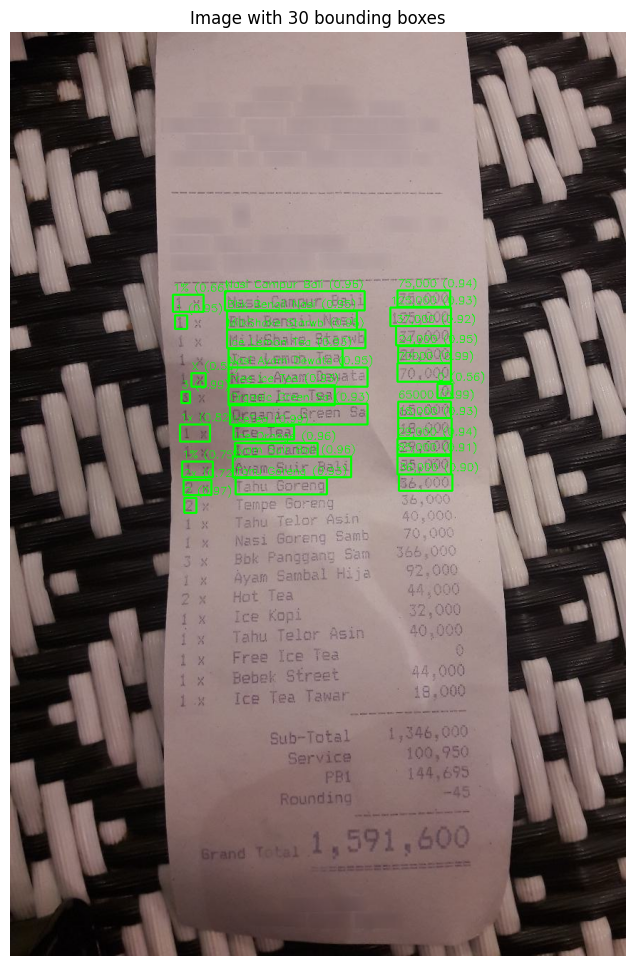

In [13]:
# Test visualization function
image = sample['image']
visualize_boxes(image, boxes, words, confidences, max_boxes=30)

In [14]:
# Function to create a text detection map
def create_text_map(boxes, image_width, image_height):
    """Create a binary text detection map from bounding boxes"""
    # Create empty text map
    text_map = np.zeros((image_height, image_width), dtype=np.float32)
    
    for box in boxes:
        x1, y1, x2, y2 = [int(coord) for coord in box]
        
        # Ensure valid coordinates
        x1 = max(0, min(x1, image_width-1))
        y1 = max(0, min(y1, image_height-1))
        x2 = max(x1+1, min(x2, image_width))
        y2 = max(y1+1, min(y2, image_height))
        
        # Fill text map
        text_map[y1:y2, x1:x2] = 1.0
    
    return text_map

In [15]:
# Function to normalize bounding boxes
def normalize_boxes(boxes, image_width, image_height):
    """Normalize bounding box coordinates to [0, 1] range"""
    normalized_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = box
        # Normalize coordinates to [0, 1] range
        norm_x1 = float(x1) / image_width
        norm_y1 = float(y1) / image_height
        norm_x2 = float(x2) / image_width
        norm_y2 = float(y2) / image_height
        normalized_boxes.append([norm_x1, norm_y1, norm_x2, norm_y2])
    return normalized_boxes

In [16]:
# Process multiple samples
def process_samples(dataset, num_samples=5):
    """Process multiple samples to test our pipeline"""
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        
        # Parse data
        words, boxes, confidences = parse_raw_data(sample)
        
        # Filter out empty boxes
        valid_indices = []
        for j, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            if x2 > x1 and y2 > y1:
                valid_indices.append(j)
        
        # Apply filter
        filtered_words = [words[j] for j in valid_indices]
        filtered_boxes = [boxes[j] for j in valid_indices]
        filtered_confidences = [confidences[j] for j in valid_indices]
        
        print(f"\nSample {i}:")
        print(f"Total boxes: {len(words)}")
        print(f"Valid boxes: {len(filtered_words)}")
        
        # Get image dimensions
        image = sample['image']
        if hasattr(image, 'width') and hasattr(image, 'height'):
            img_width, img_height = image.width, image.height
        else:
            img_height, img_width = image.shape[:2]
        
        # Create text map
        if filtered_boxes:
            text_map = create_text_map(filtered_boxes, img_width, img_height)
            
            # Visualize
            plt.figure(figsize=(15, 5))
            
            # Original image with boxes
            plt.subplot(1, 3, 1)
            img_copy = np.array(image.convert('RGB'))
            for box in filtered_boxes[:30]:  # Limit to 30 boxes for visualization
                x1, y1, x2, y2 = [int(coord) for coord in box]
                cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
            plt.imshow(img_copy)
            plt.title("Original Image with Boxes")
            plt.axis('off')
            
            # Text map
            plt.subplot(1, 3, 2)
            plt.imshow(text_map, cmap='gray')
            plt.title("Text Detection Map")
            plt.axis('off')
            
            # Original image
            plt.subplot(1, 3, 3)
            plt.imshow(np.array(image.convert('RGB')))
            plt.title("Original Image")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("No valid boxes found in this sample")


Sample 0:
Total boxes: 71
Valid boxes: 71


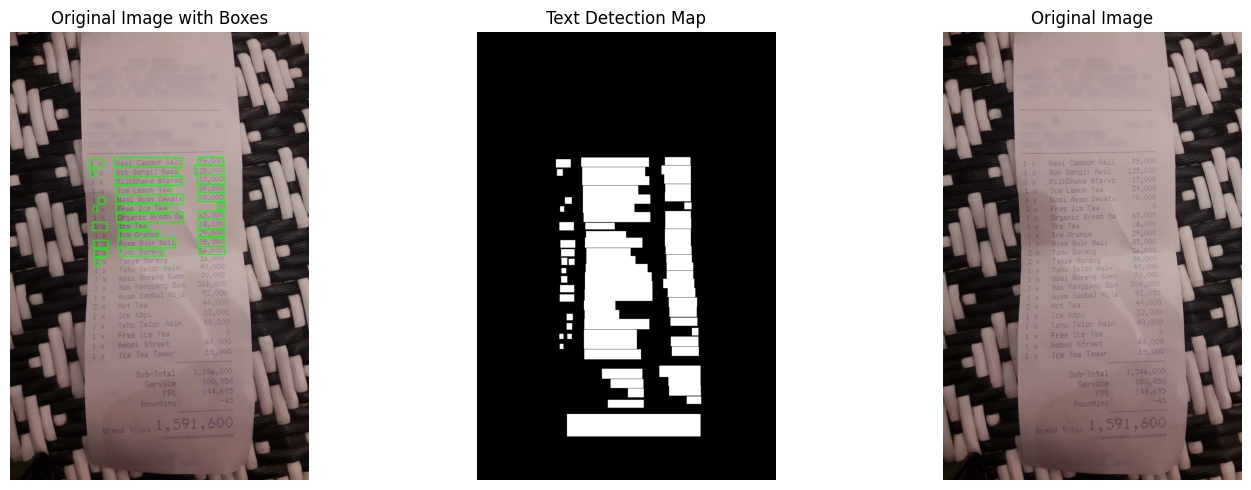


Sample 1:
Total boxes: 24
Valid boxes: 24


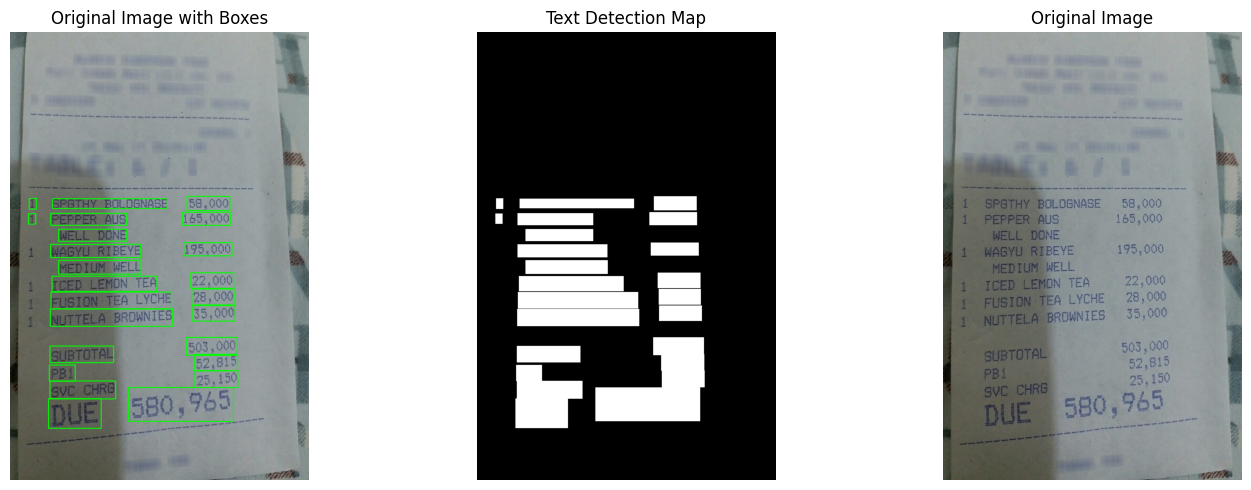


Sample 2:
Total boxes: 12
Valid boxes: 12


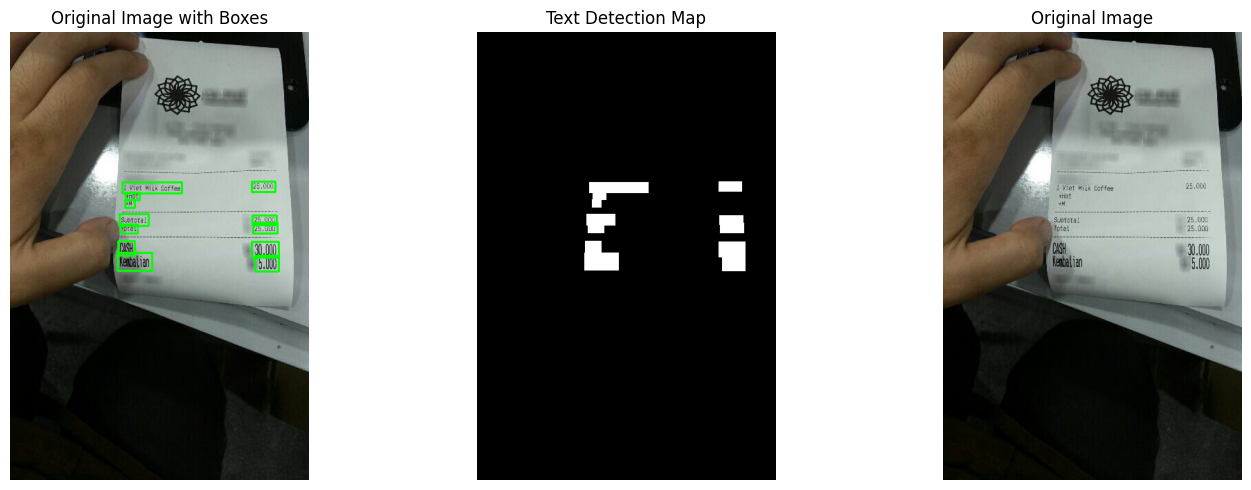

In [17]:
# Process a few samples
process_samples(dataset, num_samples=3)